In [63]:
import numpy as np, pandas as pd
from pandas import read_csv
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import multiprocessing as mp
from statsmodels.stats.stattools import durbin_watson
import os

In [64]:
# Load all fire detection data
file_path = f"C:/Users/308ca/Desktop/Graduate_Fall24_Courses/CLIMATE588_Regional_Climate_Scale/588_final/Fire_Detections_w_Landcover/all_fire_detections_2009-2019.csv"
all_fire_detections = pd.read_csv(file_path)
all_fire_detections

In [3]:
# Aggregate the data by year, including additional metrics
yearly_detections = all_fire_detections.groupby('year').agg({
    'Daily Fire Detections': 'sum',
    'LandCoverType': 'first',  # Assuming we want the first occurrence
    'LandCoverValue': 'first',
    'NDVI Value': 'mean',             # Average NDVI for the year
    'Daily Average RH %': 'mean'  # Average humidity for the year
}).reset_index().rename(columns={
    'Daily Fire Detections': 'Total Yearly Fire Detections',
    'NDVI Value': 'Average Yearly NDVI',
    'Daily Average RH %': 'Average Yearly RH %'
})

# Aggregate the data by month, including additional metrics
monthly_detections = all_fire_detections.groupby('month').agg({
    'Daily Fire Detections': 'sum',
    'LandCoverType': 'first',  # Assuming we want the first occurrence
    'LandCoverValue': 'first',
    'NDVI Value': 'mean',             # Average NDVI for the month
    'Daily Average RH %': 'mean'  # Average humidity for the month
}).reset_index().rename(columns={
    'Daily Fire Detections': 'Total Monthly Fire Detections',
    'NDVI Value': 'Average Monthly NDVI',
    'Daily Average RH %': 'Average Monthly RH %'
})

# Aggregate the data by month and year, including additional metrics
detections_by_month_year = all_fire_detections.groupby(['month', 'year']).agg({
    'Daily Fire Detections': 'sum',
    'LandCoverValue': 'first',
    'LandCoverType': 'first',  # Assuming we want the first occurrence
    'NDVI Value': 'mean',             # Average NDVI for the month and year
    'Daily Average RH %': 'mean'  # Average humidity for the month and year
}).reset_index().rename(columns={
    'Daily Fire Detections': 'Total Monthly Fire Detections',
    'NDVI Value': 'Average Monthly NDVI',
    'Daily Average RH %': 'Average Monthly RH %'
})

monthly_detections

,month,Total Monthly Fire Detections,LandCoverType,LandCoverValue,Average Monthly NDVI,Average Monthly RH %
0,5,39604,Soybeans,5,0.270865,32.518390
1,6,22182,Deciduous Forest,141,0.377821,34.645390
2,7,27159,Soybeans,5,0.426262,35.158197
3,8,30191,Corn,1,0.413343,34.333142
4,9,34693,Deciduous Forest,141,0.355278,33.167483
5,10,38184,Grassland/Pasture,176,0.259212,32.943010


In [4]:
# Plot time series of all fire detections over whole time frame using year column, each row is its own separate fire detection
# Aggregate the data by year
#yearly_detections = all_fire_detections.groupby('year')['Daily Fire Detections'].sum().reset_index()
# Aggregate the data by month
#monthly_detections = all_fire_detections.groupby('month')['Daily Fire Detections'].sum().reset_index()
# Aggregate the data by month and year
#detections_by_month_year = all_fire_detections.groupby(['month', 'year'])['Daily Fire Detections'].sum().reset_index()
#detections_by_month_year

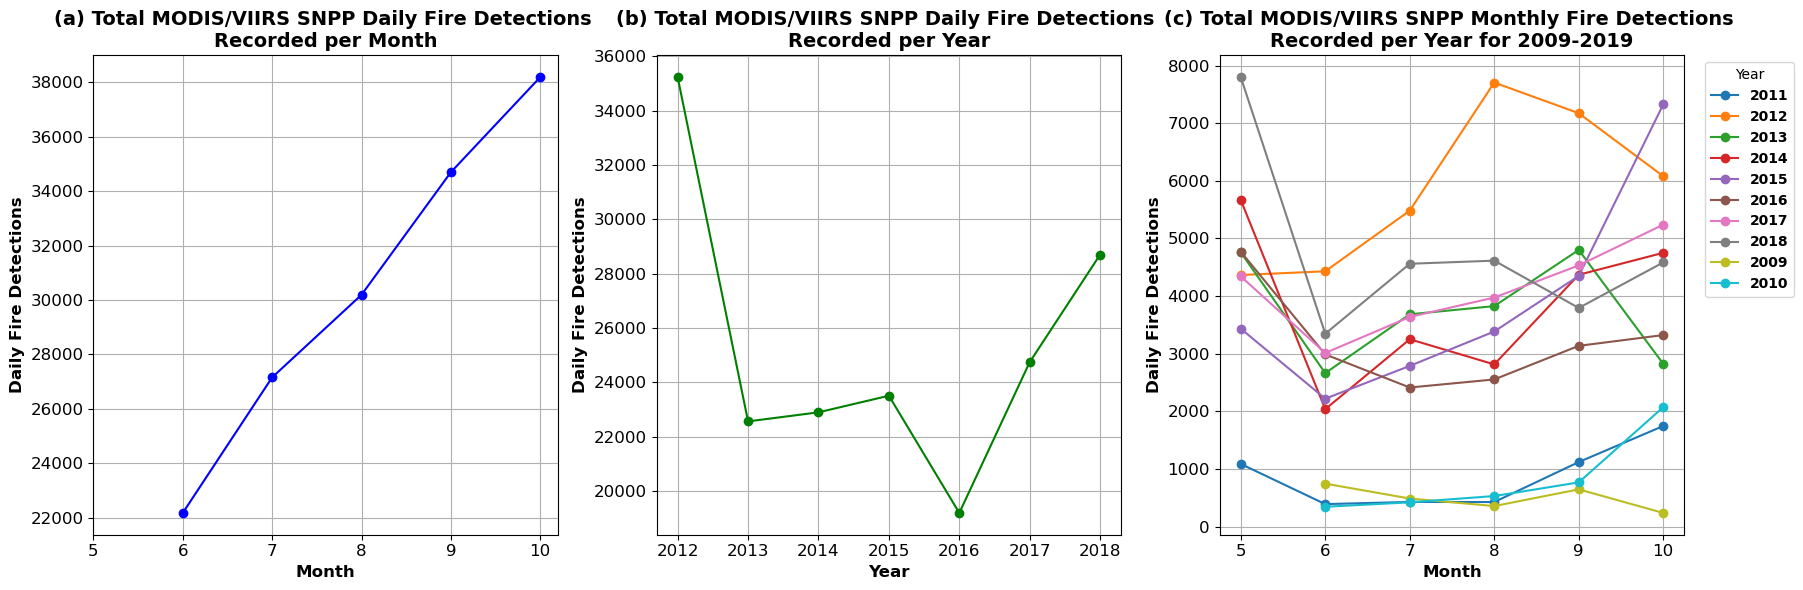

In [62]:
# Create a single figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot daily fire detections over months from monthly_detections
axs[0].plot(monthly_detections['month'], monthly_detections['Total Monthly Fire Detections'], marker='o', color='blue')
axs[0].set_title('(a) Total MODIS/VIIRS SNPP Daily Fire Detections \nRecorded per Month', fontsize=14, fontweight='bold')
axs[0].set_xlabel('Month', fontsize=12, fontweight='bold')
axs[0].set_ylabel('Daily Fire Detections', fontsize=12, fontweight='bold')
axs[0].set_xticks(range(5, 11))  
axs[0].tick_params(axis='both', labelsize=12) 
axs[0].grid()

# Plot daily fire detections over years from yearly_detections
axs[1].plot(yearly_detections['year'], yearly_detections['Total Yearly Fire Detections'], marker='o', color='green')
axs[1].set_title('(b) Total MODIS/VIIRS SNPP Daily Fire Detections \nRecorded per Year',fontsize=14, fontweight='bold')
axs[1].set_xlabel('Year', fontsize=12, fontweight='bold')
axs[1].set_ylabel('Daily Fire Detections', fontsize=12, fontweight='bold')
axs[1].set_xticks(yearly_detections['year'])  
axs[1].tick_params(axis='both', labelsize=12) 
axs[1].grid()

# Plot daily fire detections over months for each year
for year in detections_by_month_year['year'].unique():
    subset = detections_by_month_year[detections_by_month_year['year'] == year]
    axs[2].plot(subset['month'], subset['Total Monthly Fire Detections'], marker='o', label=str(year))

axs[2].set_title('(c) Total MODIS/VIIRS SNPP Monthly Fire Detections \nRecorded per Year for 2009-2019',fontsize=14, fontweight='bold')
axs[2].set_xlabel('Month', fontsize=12, fontweight='bold')
axs[2].set_ylabel('Daily Fire Detections', fontsize=12, fontweight='bold')
axs[2].set_xticks(range(5, 11))  # Set ticks for all months from 1 to 12
axs[2].tick_params(axis='both', labelsize=12) 
axs[2].legend(title='Year', loc='upper right', bbox_to_anchor=(1.25, 1), prop={'weight': 'bold'})
axs[2].grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [6]:
"""This can replace the previous multi=plot to show seasonal variability, and that we will need an order of differencing as this shows nonstationarity."""

'This can replace the previous multi=plot to show seasonal variability, and that we will need an order of differencing as this shows nonstationarity.'

In [7]:
"""Note: Further show nonstationarity with ADF test for aggregated fire detection."""

'Note: Further show nonstationarity with ADF test for aggregated fire detection.'

In [8]:
# Further show all_fire_detections data is nonstationary with ADF test for monthly, yearly, aggregated detections, and detections aggregated over both months and years.
result1 = adfuller(monthly_detections['Total Monthly Fire Detections'])
print('ADF Statistic:', result1[0])
print('Fire detections agrregated per month p-value:', result1[1])
print('Critical Values:', result1[4], "\n")
result2 = adfuller(yearly_detections['Total Yearly Fire Detections'])
print('ADF Statistic:', result2[0])
print('Fire detections agrregated per year p-value:', result2[1])
print('Critical Values:', result2[4], "\n")
result3 = adfuller(detections_by_month_year['Total Monthly Fire Detections'])
print('ADF Statistic:', result3[0])
print('Fire detections aggregated per month and year p-value:', result3[1])
print('Critical Values:', result3[4])

ADF Statistic: 0.316803276010448
Fire detections agrregated per month p-value: 0.9781024117731592
Critical Values: {'1%': -7.355440625, '5%': -4.474365000000001, '10%': -3.1269325} 

ADF Statistic: -2.0002947571442706
Fire detections agrregated per year p-value: 0.28644387338945587
Critical Values: {'1%': -4.473135048010974, '5%': -3.28988060356653, '10%': -2.7723823456790124} 

ADF Statistic: -1.1592707702465306
Fire detections aggregated per month and year p-value: 0.6908665708508295
Critical Values: {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}


In [9]:
"""Stationary time series are those whose statistical property are constant over time.  Variation around the mean have a constant amplitude, there is no trend, and it is autocorrelated.  The ARIMA model being implemented is a stationary time series forecasting equation which is linear or regressive where predictors consist of lags of the dependent variable and/or the forecast errors.  Our fire detection dataset is examined to determine if nonstationarity is present, and if so, an order of differencing is applied to achieve stationarity for the ARIMA model 'I' term."""

"Stationary time series are those whose statistical property are constant over time.  Variation around the mean have a constant amplitude, there is no trend, and it is autocorrelated.  The ARIMA model being implemented is a stationary time series forecasting equation which is linear or regressive where predictors consist of lags of the dependent variable and/or the forecast errors.  Our fire detection dataset is examined to determine if nonstationarity is present, and if so, an order of differencing is applied to achieve stationarity for the ARIMA model 'I' term."

In [10]:
"""As our p-values are above a chosen signifiance level of 0.05, or 5%, this suggests a failure to reject the null hypothesis and the aggregated data over our differing monthly and yearly time series is likely non-stationary.  This non-stationarity is further asserted as the aggregated time series data all have ADF test statistics greater than the critical values at 1, 5, and 10% significance levels, thus the null hypothesis cannot be rejected. """

'As our p-values are above a chosen signifiance level of 0.05, or 5%, this suggests a failure to reject the null hypothesis and the aggregated data over our differing monthly and yearly time series is likely non-stationary.  This non-stationarity is further asserted as the aggregated time series data all have ADF test statistics greater than the critical values at 1, 5, and 10% significance levels, thus the null hypothesis cannot be rejected. '

In [11]:
"""Hence, nonstationarity is indeed present, as seen from both the ADF test and aggregated time series plots comlpleted and an order of differnecing must be used to achieve nonstationarity."""

'Hence, nonstationarity is indeed present, as seen from both the ADF test and aggregated time series plots comlpleted and an order of differnecing must be used to achieve nonstationarity.'

ADF Statistic for 1st Order Differencing (Monthly Aggregated)
ADF Statistic: -28.965003
p-value: 0.000000
Critical Values:
	1%: -7.355
	5%: -4.474
	10%: -3.127
ADF Statistic for 1st Order Differencing (Yearly Aggregated)
ADF Statistic: -2.277070
p-value: 0.179470
Critical Values:
	1%: -4.939
	5%: -3.478
	10%: -2.844
ADF Statistic for 1st Order Differencing (Monthly and Yearly Aggregated)
ADF Statistic: -3.303319
p-value: 0.014731
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


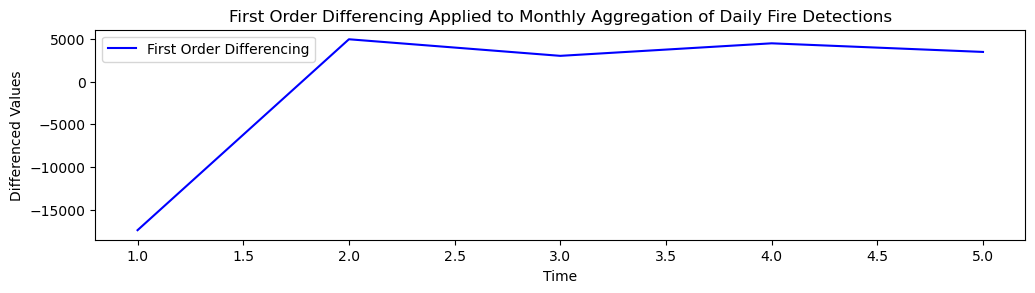

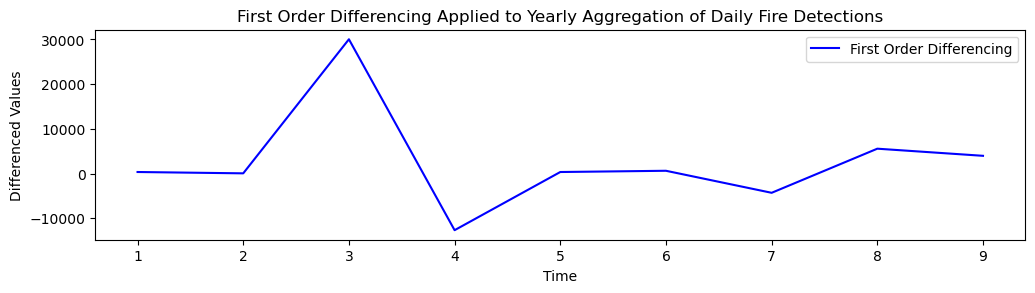

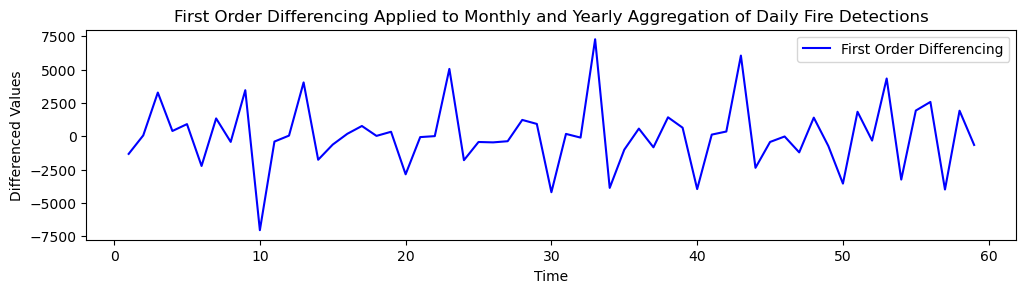

In [12]:
# First order differencing of Daily Fire Detections in monthly_detections, yearly_detections, and detections_by_month_year dataframes
# This will determine the integrated "I" term in Arima

# First Order Differencing
monthly_detections['First Order Differencing'] = monthly_detections['Total Monthly Fire Detections'].diff()
yearly_detections['First Order Differencing'] = yearly_detections['Total Yearly Fire Detections'].diff()
detections_by_month_year['First Order Differencing'] = detections_by_month_year['Total Monthly Fire Detections'].diff()

# ADF Test for First Order Differencing of monthly aggregated daily fire detections.
print('ADF Statistic for 1st Order Differencing (Monthly Aggregated)')
result_monthly = adfuller(monthly_detections['First Order Differencing'].dropna())
print('ADF Statistic: %f' % result_monthly[0])
print('p-value: %f' % result_monthly[1])
print('Critical Values:')
for key, value in result_monthly[4].items():
    print('\t%s: %.3f' % (key, value))

# ADF Test for First Order Differencing of yearly aggregated daily fire detections.
print('ADF Statistic for 1st Order Differencing (Yearly Aggregated)')
result_yearly = adfuller(yearly_detections['First Order Differencing'].dropna())
print('ADF Statistic: %f' % result_yearly[0])
print('p-value: %f' % result_yearly[1])
print('Critical Values:')
for key, value in result_yearly[4].items():
    print('\t%s: %.3f' % (key, value))

# ADF Test for First Order Differencing of monthly and yearly aggregated daily fire detections.
print('ADF Statistic for 1st Order Differencing (Monthly and Yearly Aggregated)')
result_monthly_yearly = adfuller(detections_by_month_year['First Order Differencing'].dropna())
print('ADF Statistic: %f' % result_monthly_yearly[0])
print('p-value: %f' % result_monthly_yearly[1])
print('Critical Values:')
for key, value in result_monthly_yearly[4].items():
    print('\t%s: %.3f' % (key, value))
    
# Plotting First Order Differencing for monthly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(monthly_detections['First Order Differencing'], label='First Order Differencing', color='blue')
plt.title('First Order Differencing Applied to Monthly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

# Plotting First Order Differencing for yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(yearly_detections['First Order Differencing'], label='First Order Differencing', color='blue')
plt.title('First Order Differencing Applied to Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

# Plotting First Order Differencing for monthly and yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(detections_by_month_year['First Order Differencing'], label='First Order Differencing', color='blue')
plt.title('First Order Differencing Applied to Monthly and Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

In [13]:
"""Above, the p-value for monthly aggregated detections is below our chosen significance level of 0.05, and the ADF test statistic is far below the critical values. The monthly aggregated data is now stationary after first order differencing is applied amd first order differencing is used for our intergrated 'I' term when applying ARIMA to monthly aggregated detections."""

"Above, the p-value for monthly aggregated detections is below our chosen significance level of 0.05, and the ADF test statistic is far below the critical values. The monthly aggregated data is now stationary after first order differencing is applied amd first order differencing is used for our intergrated 'I' term when applying ARIMA to monthly aggregated detections."

In [14]:
"""However, the p-value for the yearly aggregated data is still greater than 0.05 and its ADF test statistic is still greater than the three critical value significance levels at 1, 5, and 10%. The p-value for the combined monthly and yearly aggregated data is less than the chosen significance level of 0.05, but the ADF test statistic is greater than the three critical value significance levels at 1, 5, and 10%. Second order differencing is therefore required to make the yearly aggregated and combined monthly and yearly aggregated fire detection data stationary."""

'However, the p-value for the yearly aggregated data is still greater than 0.05 and its ADF test statistic is still greater than the three critical value significance levels at 1, 5, and 10%. The p-value for the combined monthly and yearly aggregated data is less than the chosen significance level of 0.05, but the ADF test statistic is greater than the three critical value significance levels at 1, 5, and 10%. Second order differencing is therefore required to make the yearly aggregated and combined monthly and yearly aggregated fire detection data stationary.'

ADF Statistic for 2nd Order Differencing (Yearly Aggregated)
ADF Statistic: -1.060789
p-value: 0.730453
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987
ADF Statistic for 2nd Order Differencing (Monthly and Yearly Aggregated)
ADF Statistic: -5.624716
p-value: 0.000001
Critical Values:
	1%: -3.581
	5%: -2.927
	10%: -2.602


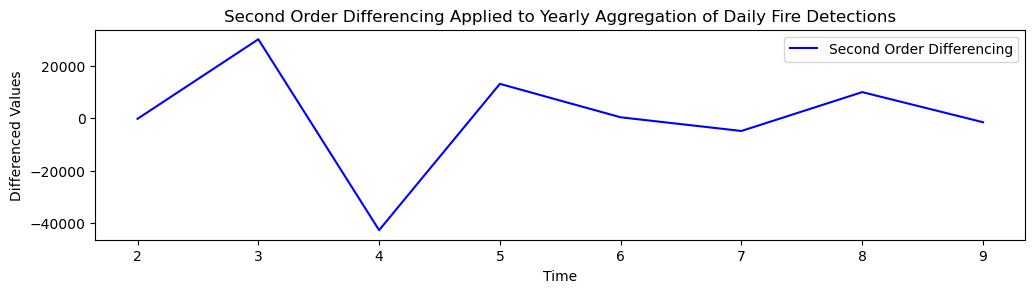

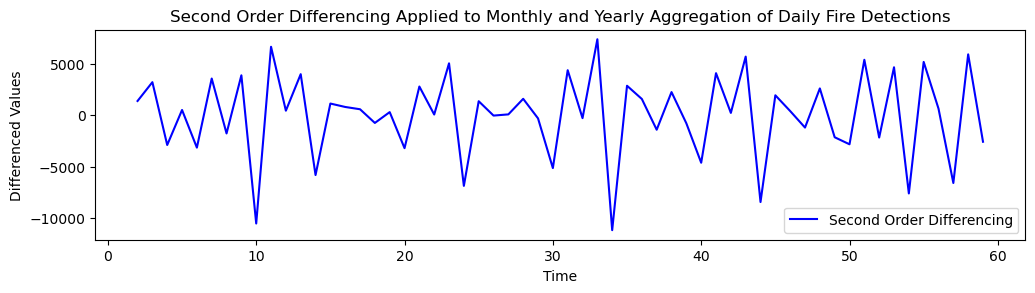

In [15]:
# Second order differencing applied to yearly and monthly/yearly aggregated fire detection data.
# Second Order Differencing
yearly_detections['Second Order Differencing'] = yearly_detections['Total Yearly Fire Detections'].diff().diff()
detections_by_month_year['Second Order Differencing'] = detections_by_month_year['Total Monthly Fire Detections'].diff().diff()

# ADF Test for Second Order Differencing of yearly aggregated daily fire detections.
print('ADF Statistic for 2nd Order Differencing (Yearly Aggregated)')
result_yearly = adfuller(yearly_detections['Second Order Differencing'].dropna())
print('ADF Statistic: %f' % result_yearly[0])
print('p-value: %f' % result_yearly[1])
print('Critical Values:')
for key, value in result_yearly[4].items():
    print('\t%s: %.3f' % (key, value))

# ADF Test for Second Order Differencing of monthly and yearly aggregated daily fire detections.
print('ADF Statistic for 2nd Order Differencing (Monthly and Yearly Aggregated)')
result_monthly_yearly = adfuller(detections_by_month_year['Second Order Differencing'].dropna())
print('ADF Statistic: %f' % result_monthly_yearly[0])
print('p-value: %f' % result_monthly_yearly[1])
print('Critical Values:')
for key, value in result_monthly_yearly[4].items():
    print('\t%s: %.3f' % (key, value))

# Plotting Second Order Differencing for yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(yearly_detections['Second Order Differencing'], label='Second Order Differencing', color='blue')
plt.title('Second Order Differencing Applied to Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

# Plotting Second Order Differencing for monthly and yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(detections_by_month_year['Second Order Differencing'], label='Second Order Differencing', color='blue')
plt.title('Second Order Differencing Applied to Monthly and Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

In [16]:
"""Above, the p-value for monthly and yearly aggregated detections is below our chosen significance level of 0.05, and the ADF test statistic is below the critical values. The monthly and yearly aggregated data is now stationary after a second order differencing is applied amd second order differencing is used for our intergrated 'I' term when applying ARIMA to combined monthly and yearly aggregated detections."""

"Above, the p-value for monthly and yearly aggregated detections is below our chosen significance level of 0.05, and the ADF test statistic is below the critical values. The monthly and yearly aggregated data is now stationary after a second order differencing is applied amd second order differencing is used for our intergrated 'I' term when applying ARIMA to combined monthly and yearly aggregated detections."

In [17]:
"""As the gap between our yearly aggregated detection data p-value and our 0.05 chosen significance level has increased and the ADF test statistic is still greater than the critical value significant levels, we will try third order differencing of the yearly aggregated data."""

'As the gap between our yearly aggregated detection data p-value and our 0.05 chosen significance level has increased and the ADF test statistic is still greater than the critical value significant levels, we will try third order differencing of the yearly aggregated data.'

ADF Statistic for 3rd Order Differencing (Yearly Aggregated)
ADF Statistic: -18.132729
p-value: 0.000000
Critical Values:
	1%: -6.045
	5%: -3.929
	10%: -2.987


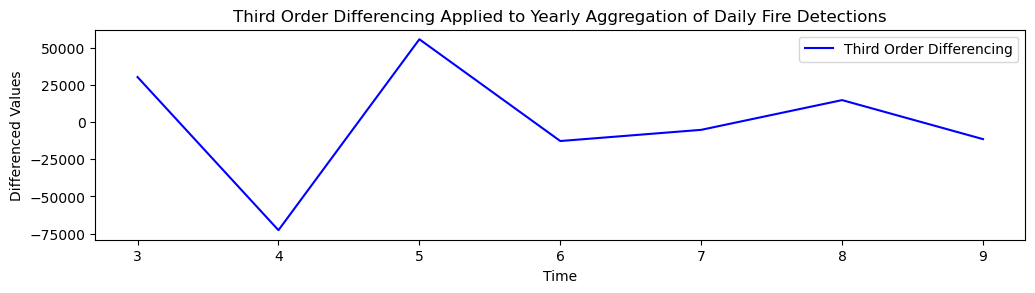

In [18]:
# Third Order Differencing
yearly_detections['Third Order Differencing'] = yearly_detections['Total Yearly Fire Detections'].diff().diff().diff()

# ADF Test for Second Order Differencing of yearly aggregated daily fire detections.
print('ADF Statistic for 3rd Order Differencing (Yearly Aggregated)')
result_yearly = adfuller(yearly_detections['Third Order Differencing'].dropna())
print('ADF Statistic: %f' % result_yearly[0])
print('p-value: %f' % result_yearly[1])
print('Critical Values:')
for key, value in result_yearly[4].items():
    print('\t%s: %.3f' % (key, value))

# Plotting Third Order Differencing for yearly aggregated daily fire detections.
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(yearly_detections['Third Order Differencing'], label='Third Order Differencing', color='blue')
plt.title('Third Order Differencing Applied to Yearly Aggregation of Daily Fire Detections')
plt.xlabel('Time')
plt.ylabel('Differenced Values')
plt.legend()

In [19]:
"""Third order differencing has finally resulted in the yearly aggregated detection data p-value being lower than 0.05, and the ADF test statistic being much lower than the critical value significance levels.  Now that the intergreated term order of differencing for our three types of aggregated fire data that will be implemented in ARIMA have been determined, we can move on to determining the autoregressioin (AR) and moving average (MA) terms."""

'Third order differencing has finally resulted in the yearly aggregated detection data p-value being lower than 0.05, and the ADF test statistic being much lower than the critical value significance levels.  Now that the intergreated term order of differencing for our three types of aggregated fire data that will be implemented in ARIMA have been determined, we can move on to determining the autoregressioin (AR) and moving average (MA) terms.'

In [20]:
"""We determine whether the aggregated fire detection datasets are autocorrelated via a Durbin-Watson statistic test for first order differenced data, which would be the monthly aggregated data only. A statistic determines the autocorrelation of multiple linear regression model residuals.  If the autocorrelation is positive, this generally means an AR term can be added to the model, and if the autocorrelation is negative, this generally means an MA term can be added instead (Fuqua School of Business, n.d.).  The Durbin-Watson test can result in statistics between 0 and 4. An obtained statistic less than two indicates positive autocorrelation, a statistic of 2 indicates no correlation, and if above two there is negative correlation."""

'We determine whether the aggregated fire detection datasets are autocorrelated via a Durbin-Watson statistic test for first order differenced data, which would be the monthly aggregated data only. A statistic determines the autocorrelation of multiple linear regression model residuals.  If the autocorrelation is positive, this generally means an AR term can be added to the model, and if the autocorrelation is negative, this generally means an MA term can be added instead (Fuqua School of Business, n.d.).  The Durbin-Watson test can result in statistics between 0 and 4. An obtained statistic less than two indicates positive autocorrelation, a statistic of 2 indicates no correlation, and if above two there is negative correlation.'

In [21]:
"""The mathematics of a Durbin-Watson test as applied to a multiple linear regression model case can be further explored in (Durbin & Watson, 2008)."""

'The mathematics of a Durbin-Watson test as applied to a multiple linear regression model case can be further explored in (Durbin & Watson, 2008).'

In [22]:
yearly_detections = yearly_detections.drop(columns=['First Order Differencing', 'Second Order Differencing'])
detections_by_month_year = detections_by_month_year.drop(columns=['First Order Differencing'])

In [23]:
"""First, a multiple linear regression model is fitted to the monthly agreggated dataset that has been differenced to be stationary.  The dependent variable is fire detections.  Independent variables are landcover type, average relative humidity percentages, and NDVI values by month, year, or month and year as with the fire detectino time-series agggregation.  By determining autocorrelation through a multiple linear regression model fit, we take into account the earlier one-to-one mapped environmental variables associated with fire detection likelihoods and information."""

'First, a multiple linear regression model is fitted to the monthly agreggated dataset that has been differenced to be stationary.  The dependent variable is fire detections.  Independent variables are landcover type, average relative humidity percentages, and NDVI values by month, year, or month and year as with the fire detectino time-series agggregation.  By determining autocorrelation through a multiple linear regression model fit, we take into account the earlier one-to-one mapped environmental variables associated with fire detection likelihoods and information.'

In [24]:
# Fit multiple linear regression model to first order differentiated monthly detections
# In order to indlude landcover types in the model, their original values corresponding to strings such as deciduous forest will be used to obtain numeric values
# drop na values from dataframe
monthly_detections.dropna(inplace=True)

# Convert columns to numeric
monthly_detections['Average Monthly NDVI'] = pd.to_numeric(monthly_detections['Average Monthly NDVI'], errors='coerce')
monthly_detections['Average Monthly RH %'] = pd.to_numeric(monthly_detections['Average Monthly RH %'], errors='coerce')
monthly_detections['Total Monthly Fire Detections'] = pd.to_numeric(monthly_detections['Total Monthly Fire Detections'], errors='coerce')
monthly_detections['LandCoverValue'] = pd.to_numeric(monthly_detections['LandCoverValue'], errors='coerce')

# Fit multiple linear regression model to first order differentiated monthly detections
X = monthly_detections[['Average Monthly NDVI', 'LandCoverValue', 'Average Monthly RH %']]  # Independent variables
y = monthly_detections['Total Monthly Fire Detections']  # Dependent variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the multiple linear regression model
model_monthly = sm.OLS(y, X).fit()

# View model summary
#print(model_monthly.summary())

# Perform Durbin-Watson test on monthly detection model
durbin_watson(model_monthly.resid)

3.473729892623951

In [25]:
# Repeat for yearly and the monthly and yearly aggregated data to do ACF plot of fitted multiple linear regression model residual coefficiencts.

yearly_detections.dropna(inplace=True)

# Convert columns to numeric
yearly_detections['Average Yearly NDVI'] = pd.to_numeric(yearly_detections['Average Yearly NDVI'], errors='coerce')
yearly_detections['Average Yearly RH %'] = pd.to_numeric(yearly_detections['Average Yearly RH %'], errors='coerce')
yearly_detections['Total Yearly Fire Detections'] = pd.to_numeric(yearly_detections['Total Yearly Fire Detections'], errors='coerce')
yearly_detections['LandCoverValue'] = pd.to_numeric(yearly_detections['LandCoverValue'], errors='coerce')

# Fit multiple linear regression model to first order differentiated monthly detections
X = yearly_detections[['Average Yearly NDVI', 'LandCoverValue', 'Average Yearly RH %']]  # Independent variables
y = yearly_detections['Total Yearly Fire Detections']  # Dependent variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the multiple linear regression model
model_yearly = sm.OLS(y, X).fit()

# View model summary
#print(model.summary())

# drop na value rows from dataframe
detections_by_month_year.dropna(inplace=True)

# Convert columns to numeric
detections_by_month_year['Average Monthly NDVI'] = pd.to_numeric(detections_by_month_year['Average Monthly NDVI'], errors='coerce')
detections_by_month_year['Average Monthly RH %'] = pd.to_numeric(detections_by_month_year['Average Monthly RH %'], errors='coerce')
detections_by_month_year['Total Monthly Fire Detections'] = pd.to_numeric(detections_by_month_year['Total Monthly Fire Detections'], errors='coerce')
detections_by_month_year['LandCoverValue'] = pd.to_numeric(detections_by_month_year['LandCoverValue'], errors='coerce')

# Fit multiple linear regression model to first order differentiated monthly detections
X = detections_by_month_year[['Average Monthly NDVI', 'LandCoverValue', 'Average Monthly RH %']]  # Independent variables
y = detections_by_month_year['Total Monthly Fire Detections']  # Dependent variable

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the multiple linear regression model
model_monthly_yearly = sm.OLS(y, X).fit()

# View model summary
#print(model_monthly_yearly.summary())

# Perform Durbin-Watson test on monthly and yearly detection model
durbin_watson(model_monthly_yearly.resid)

1.6921012801465223

In [26]:
"""The monthly aggregated fire detection dataset from 1st order differencing is negatively autocorrelated with a statistic greater than 2 at about 3.47."""

'The monthly aggregated fire detection dataset from 1st order differencing is negatively autocorrelated with a statistic greater than 2 at about 3.47.'

In [27]:
"""As higher order differencing from the other time-series aggregated datasets can affect model structure and outcomes, and in order to reinforce above monthly aggregated data autocorrelation outcomes, an ACF plot will be used to further determine positive or negative or no autocorrelation present."""

'As higher order differencing from the other time-series aggregated datasets can affect model structure and outcomes, and in order to reinforce above monthly aggregated data autocorrelation outcomes, an ACF plot will be used to further determine positive or negative or no autocorrelation present.'

In [28]:
"""By the same independent and dependent variable parameters as the monthly aggregated data, a fitted multiple linear regression model is reapplied to the yearly and monthly and yearly combined aggregated data to complete ACF plots."""

'By the same independent and dependent variable parameters as the monthly aggregated data, a fitted multiple linear regression model is reapplied to the yearly and monthly and yearly combined aggregated data to complete ACF plots.'

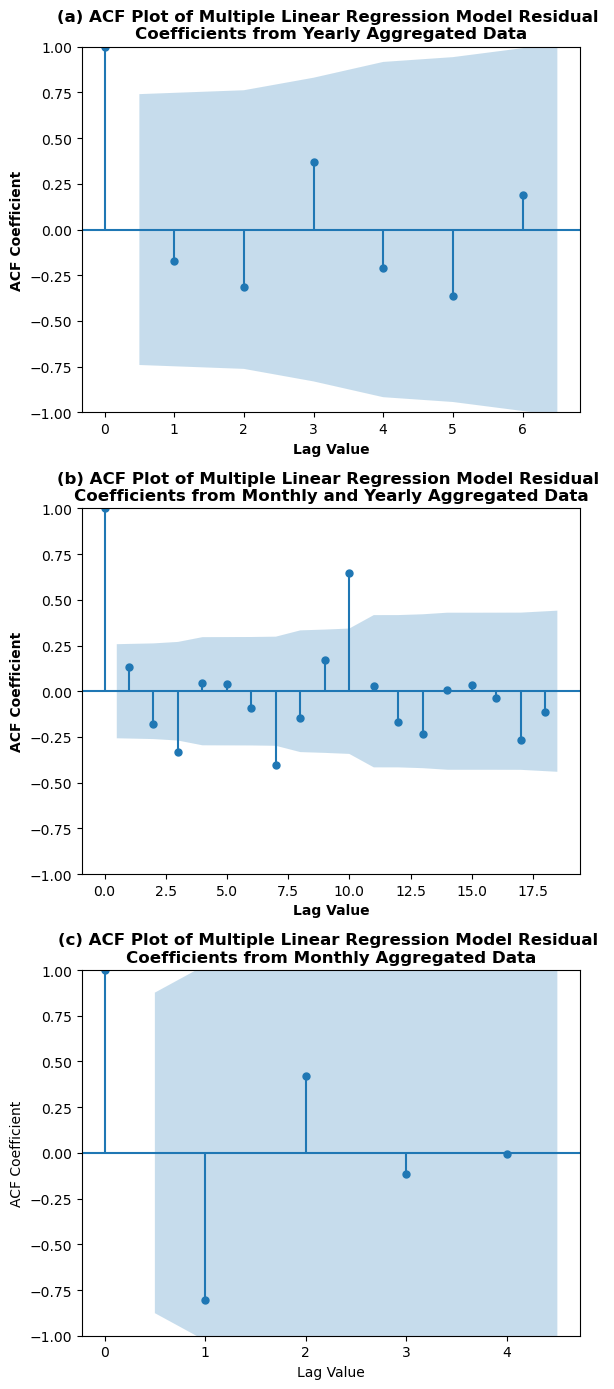

In [60]:
# Create a figure with a 2x1 subplot
fig, axs = plt.subplots(3, 1, figsize=(6, 14))

# Plot ACF for yearly aggregated data
plot_acf(model_yearly.resid, ax=axs[0])
axs[0].set_title('(a) ACF Plot of Multiple Linear Regression Model Residual \nCoefficients from Yearly Aggregated Data', fontweight='bold')
axs[0].set_xlabel('Lag Value', fontweight='bold')
axs[0].set_ylabel('ACF Coefficient', fontweight='bold')

# Plot ACF for monthly & yearly aggregated data
plot_acf(model_monthly_yearly.resid, ax=axs[1])
axs[1].set_title('(b) ACF Plot of Multiple Linear Regression Model Residual \nCoefficients from Monthly and Yearly Aggregated Data', fontweight='bold')
axs[1].set_xlabel('Lag Value', fontweight='bold')
axs[1].set_ylabel('ACF Coefficient', fontweight='bold')

# Plot ACF for monthly data
plot_acf(model_monthly.resid, ax=axs[2])
axs[2].set_title('(c) ACF Plot of Multiple Linear Regression Model Residual \nCoefficients from Monthly Aggregated Data', fontweight='bold')
axs[2].set_xlabel('Lag Value')
axs[2].set_ylabel('ACF Coefficient')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [29]:
"""All coefficients falling within the light blue confidence band and at lag-0 are considered not statistically significant."""

'All coefficients falling within the light blue confidence band and at lag-0 are considered not statistically significant.'

In [30]:
"""As the ACF coefficients all fall within the blue confidence band, this proves there is no autocorrelation in the yearly aggregated fire detection datasets of higher order differencing. """

'As the ACF coefficients all fall within the blue confidence band, this proves there is no autocorrelation in the yearly aggregated fire detection datasets of higher order differencing. '

In [31]:
"""Again, as nearly all ACF coefficients fall within the blue confidence band, this proves there is no autocorrelation in the combined monthly and yearly aggregated fire detection datasets of higher order differencing."""

'Again, as nearly all ACF coefficients fall within the blue confidence band, this proves there is no autocorrelation in the combined monthly and yearly aggregated fire detection datasets of higher order differencing.'

In [54]:
"""After completing an ACF plot where all coefficients are statistically insignificant within the light blue confidence band for monthly aggregated data again, it is evident for now that all our time-series aggregated datasets are stationary and not autocorrelated.  """

'After completing an ACF plot where all coefficients are statistically insignificant within the light blue confidence band for monthly aggregated data again, it is evident for now that all our time-series aggregated datasets are stationary and not autocorrelated.  '